# Exploratory Data Analysis
In this notebook, I will do basic EDA to get a preliminary understanding of raw data.<br>
For the records related to project description, progress, challenge and solution, please refer to [TBrain 2021 Esun AI](https://hackmd.io/_Vmlnai6QT2ou6er4Vbwww).

In [2]:
# Import packages
import os 
import sys
import gc
import csv
import warnings
from random import random, sample
import json
import pickle
from tqdm import tqdm

import pandas as pd
# import modin.pandas as mpd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from metadata import *
from fe import *

# Configurations
warnings.simplefilter('ignore')
pd.set_option('max_column',  300)
pd.set_option('max_row', 100)
%matplotlib inline

In [2]:
# Variable definitions 

In [17]:
# Utility function definitions
def proc_sub_df(buffer):
    '''Process sub dataframe, including NaN imputation and dtype conversion.
    
    Parameters:
        buffer: list, subset of the data samples
    
    Return:
        df_tmp: pd.DataFrame, processed dataframe
    '''
    df_tmp = pd.DataFrame(buffer, columns=cols)
    df_tmp.replace(to_replace={'shop_tag': {'other': '49'}}, value=None, inplace=True)
    df_tmp.replace(to_replace='', value=np.nan, inplace=True)
    df_tmp = df_tmp.astype(dtype='float32')
    
    return df_tmp

# 1. Basic Description
The most important thing to notice is the **limitation of RAM**, I shrink down the data size I read in. Then, I use this subset of the raw data to help me get a quick sense about what's the data appearance and behavior. 
## a. Data Appearance
Understanding what the data looks like can help me gain a preliminary sense about how to do the further data processing and analysis.
### Analysis and Observation
1. Shape of raw data is (32975653, 53).
2. All the entries are with dtype `str`, which takes up to 49 bytes per string even if it's empty.

In [3]:
# Check shape of raw dataframe 
# with open("./tbrain_cc_training_48tags_hash_final.csv", newline='') as f:
#     c = 0
#     for i, l in enumerate(csv.reader(f)):
#         c += 1
#     print(f"#Samples {c}")

In [ ]:
# Read a subset of whole raw data to check #columns
cols = []
buffer = []
# print(f"Ref count of list buffer is {sys.getrefcount(buffer)}")
with open("./tbrain_cc_training_48tags_hash_final.csv", newline='') as f: 
    for i, l in enumerate(csv.reader(f)):
        if i == 0:
            cols = l
            continue
        if i == 10e4:
            break
        buffer.append(l)
#         print(f"Ref count of list buffer is {sys.getrefcount(buffer)}")
df = pd.DataFrame(buffer, columns=cols) 
print(f"#Columns (PK + features) {len(cols)}")

In [ ]:
# Check entry size
print("=====Entry size (take random chid and txn_amt)=====")
print(f"One customer identifier takes {sys.getsizeof(df['chid'][0])} bytes.")
print(f"One transaction amount takes {sys.getsizeof(df['txn_amt'][100])} bytes.")

## b. Data Types
To convert each column to suitable data type to **reduce memory loading**, I perform the following processing and analysis tricks.
### Analysis and Observation
1. By checking upper and lower bounds of each column, I select the best dtype for each column manually. For more detailed information about column dtypes, please refer to [feat_bounds.json](./feat_bounds.json).
2. Dtype conversion faces a challenge when there's any NaN in the column, which is represented as **empty string ""** in this case. Hence, I check NaN columns first, then impute them with proper values in advanece to avoid the conversion error (*i.e.*, when there's NaN in column, it's impossible to convert it to dtypy like `np.int8`.).

In [ ]:
# Check upper and lower bounds of each column, 
# helping determine dtypes to convert to
def update_bounds(buffer):
    '''Update lower and upper bounds of each feature.
    
    Parameters:
        buffer: list, subset of the data samples
    
    Return:
        None
    '''
    df_tmp = proc_sub_df(buffer)
    min_max_tmp = df_tmp.describe().loc[['min', 'max'], :]
    for col in min_max_tmp:
        if min_max_tmp[col]['min'] < bound_map[col]['min']:
            bound_map[col]['min'] = min_max_tmp[col]['min']
        if min_max_tmp[col]['max'] > bound_map[col]['max']:
            bound_map[col]['max'] = min_max_tmp[col]['max']
        
cols = []
buffer = []
bound_map = {k: {'min': 10e18, 'max': 10e-18} for k in df.columns}
with open("./tbrain_cc_training_48tags_hash_final.csv", newline='') as f: 
    for i, l in enumerate(csv.reader(f)):
        if i == 0:
            continue
        buffer.append(l)
        if i % 10e4 == 0 or i == N_LINES-1:
            # Update boundaries every 10^5 samples
            print(f"Start updating boundaries | round{i//10e4}...")
            update_bounds(buffer)
            del buffer 
            buffer = []
            
with open("./feat_bounds.json", 'w') as f:
    json.dump(bound_map, f)

In [ ]:
# Check if there's NaN value in each column
def check_nan(buffer):
    '''Check if there's NaN value (empty string) within each column.
    
    Parameters:
        buffer: list, subset of the data samples
        
    Return:
        sub_cols_with_nan: list, column names of columns with NaN values
    '''
    df_tmp = proc_sub_df(buffer)
    nans = pd.isna(df_tmp).any()
    sub_cols_with_nan = df_tmp.columns[nans].tolist()
    
    return sub_cols_with_nan
    
buffer = []
cols_with_nan = []
with open("./tbrain_cc_training_48tags_hash_final.csv", newline='') as f: 
    for i, l in enumerate(csv.reader(f)):
        if i == 0:
            continue
        buffer.append(l)
        if i % 10e4 == 0 or i == N_LINES-1:
            # Check NaN every 10^5 samples
            print(f"Start check NaN | round{i//10e4}...")
            cols_with_nan += check_nan(buffer)
            del buffer 
            buffer = []
print(f"Columns with NaN values (empty strings): {set(cols_with_nan)}.")

In [ ]:
# Generate complete raw data
# df = pd.DataFrame()
# for file in tqdm(sorted(os.listdir("./data"))):
#     df_ = pd.read_parquet(os.path.join("./data", file))
#     df = pd.concat([df, df_], ignore_index=True)
#     del df_
# df.to_parquet("./raw_data.parquet", index=False)

# 2. Advanced Data Analysis
After obtaining the complete raw data and having a sence about what data looks like, I need to do advanced data analysis, including **univariate** data analysis, **multivariate** interaction, etc. At the same time, I want to find out if there's any sample containing unreasonable value in each column (*e.g.*, negative transaction count).

## a. Univariate Analysis
In the first step, I want to observe how each variable behaves independently; that is, I'll use a single **bar chart** or **histogram** to see the discrete or continuos value distribution.
### Analysis and Observation
1. The interpretation of value counts and distribution of variable is recorded [here](https://hackmd.io/vIC1fF5uSnSnGYrv2GBUsA).

<div class='alert alert-warning'>
    <p>
        <strong>(Solved)</strong>2. Analyzing upper and lower bounds of each continuous variable helps us find out an unreasonable issue. That is, all features related to transaction count have negative values located in some samples. I'll wait for response from the host.
     </p>
</div>

3. The interpretation of the boxplots is recorded [here](https://hackmd.io/vIC1fF5uSnSnGYrv2GBUsA), same as above.
4. Nearly 60% of **continuous** features have zero ratios greater than 0.9, and 80% greater than 0.8. 
5. No NaN values are left to be processed.
6. Observing featmaps with two axes (both spatial and temporal), I simply conclude that temporal patterns are hard to find by merely visualization. Furthermore, most clients seem to consume the specific subsets of `shop_tag`s.
7. Number of `shop_tag`s each client has consumed follows **curved power law**.
8. Average number of `shop_tag`s each client consumed per month follows **power law**, indicating that the majority of clients focus on small subsets of `shop_tag`s.
9. Quantile report shows that average number of `shop_tag`s each client consumed per month tends to be a small number, and there's the special case of only 1 `shop_tag`. Also, 98% of clients have this value less than or equal to 10 `shop_tag`s.
10. Nealy 60% of clients have their first transaction at month 1. And there are more and more clients joining in.

In [3]:
# Prepare data to analyze 
df = pd.read_parquet("./raw_data.parquet")
print(f"Shape of raw data: {df.shape}")
N_SAMPLES = len(df)

# Display all the columns
df.columns

Shape of raw data: (32975653, 53)


Index(['dt', 'chid', 'shop_tag', 'txn_cnt', 'txn_amt', 'domestic_offline_cnt',
       'domestic_online_cnt', 'overseas_offline_cnt', 'overseas_online_cnt',
       'domestic_offline_amt_pct', 'domestic_online_amt_pct',
       'overseas_offline_amt_pct', 'overseas_online_amt_pct', 'card_1_txn_cnt',
       'card_2_txn_cnt', 'card_3_txn_cnt', 'card_4_txn_cnt', 'card_5_txn_cnt',
       'card_6_txn_cnt', 'card_7_txn_cnt', 'card_8_txn_cnt', 'card_9_txn_cnt',
       'card_10_txn_cnt', 'card_11_txn_cnt', 'card_12_txn_cnt',
       'card_13_txn_cnt', 'card_14_txn_cnt', 'card_other_txn_cnt',
       'card_1_txn_amt_pct', 'card_2_txn_amt_pct', 'card_3_txn_amt_pct',
       'card_4_txn_amt_pct', 'card_5_txn_amt_pct', 'card_6_txn_amt_pct',
       'card_7_txn_amt_pct', 'card_8_txn_amt_pct', 'card_9_txn_amt_pct',
       'card_10_txn_amt_pct', 'card_11_txn_amt_pct', 'card_12_txn_amt_pct',
       'card_13_txn_amt_pct', 'card_14_txn_amt_pct', 'card_other_txn_amt_pct',
       'masts', 'educd', 'trdtp', 'naty

In [6]:
# Display basic stats
# df.describe()

In [ ]:
def plot_bar(cols_discrete):
    '''Plot bar chart to display the count of each discrete value.
    
    Parameters:
        cols_discrete: list, columns with discrete values
        
    Return:
        None
    '''
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(14, 7))    
    for i, col_name in enumerate(cols_discrete):
        val_cnts = df[col_name].value_counts()
        val_cnts.sort_index(axis=0, ascending=True, inplace=True)
        axs[i//4, i%4].bar(x=list(val_cnts.index), height=list(val_cnts.values))
        axs[i//4, i%4].set_title(f"Value Counts of Column {col_name}\nwith {len(val_cnts)} Unique Values")
        axs[i//4, i%4].set_xlabel(f"{col_name}")
        axs[i//4, i%4].set_ylabel("Value Count")
        del val_cnts
    plt.tight_layout()
    
def plot_hist(cols_cont):
    '''Plot histogram to display the distribution of each continuous value.
    
    Parameters:
        cols_cont: list, columns with continuous values
        
    Return:
        None
    '''
    n_cols = 3
    fig, axs = plt.subplots(nrows=14, ncols=n_cols, figsize=(35, 85))
    for i, col_name in enumerate(cols_cont):
        axs[i//n_cols, i%n_cols].hist(x=df[col_name], bins=250)
        axs[i//n_cols, i%n_cols].set_title(f"Distribution of Column {col_name}")
        axs[i//n_cols, i%n_cols].set_xlabel(f"{col_name}")
        axs[i//n_cols, i%n_cols].set_ylabel("Binned Value Count")
    
    plt.tight_layout()

DISCRETE_VARS = [col for col in df.columns if not (col.endswith('amt') or col.endswith('cnt') or col.endswith('pct') or col == 'slam')]
CONT_VARS = [col for col in df.columns if col not in DISCRETE_VARS+['chid']]

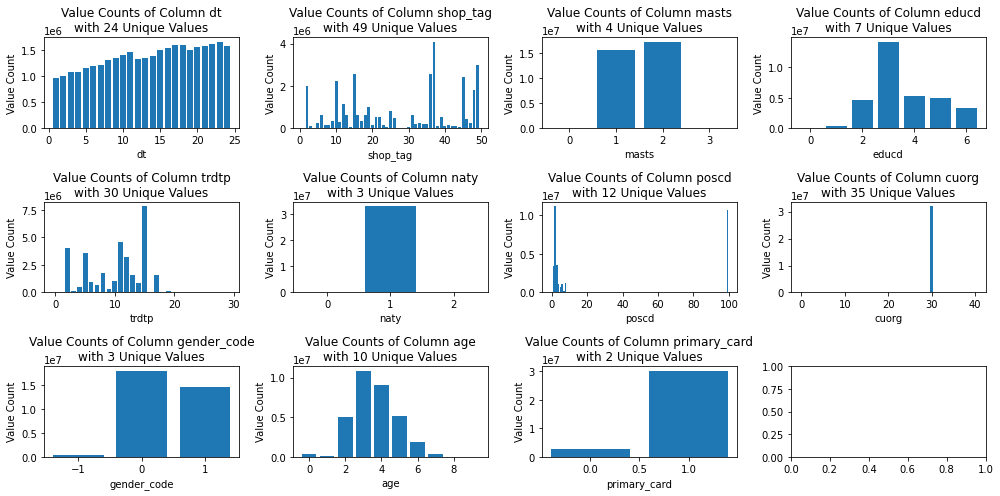

In [8]:
# 1.a Display univariate value counts for discrete variables using bar chart
DISCRETE_VARS.remove('chid')   # #Clients is too large to fit in a plot (0.5M)
plot_bar(DISCRETE_VARS)

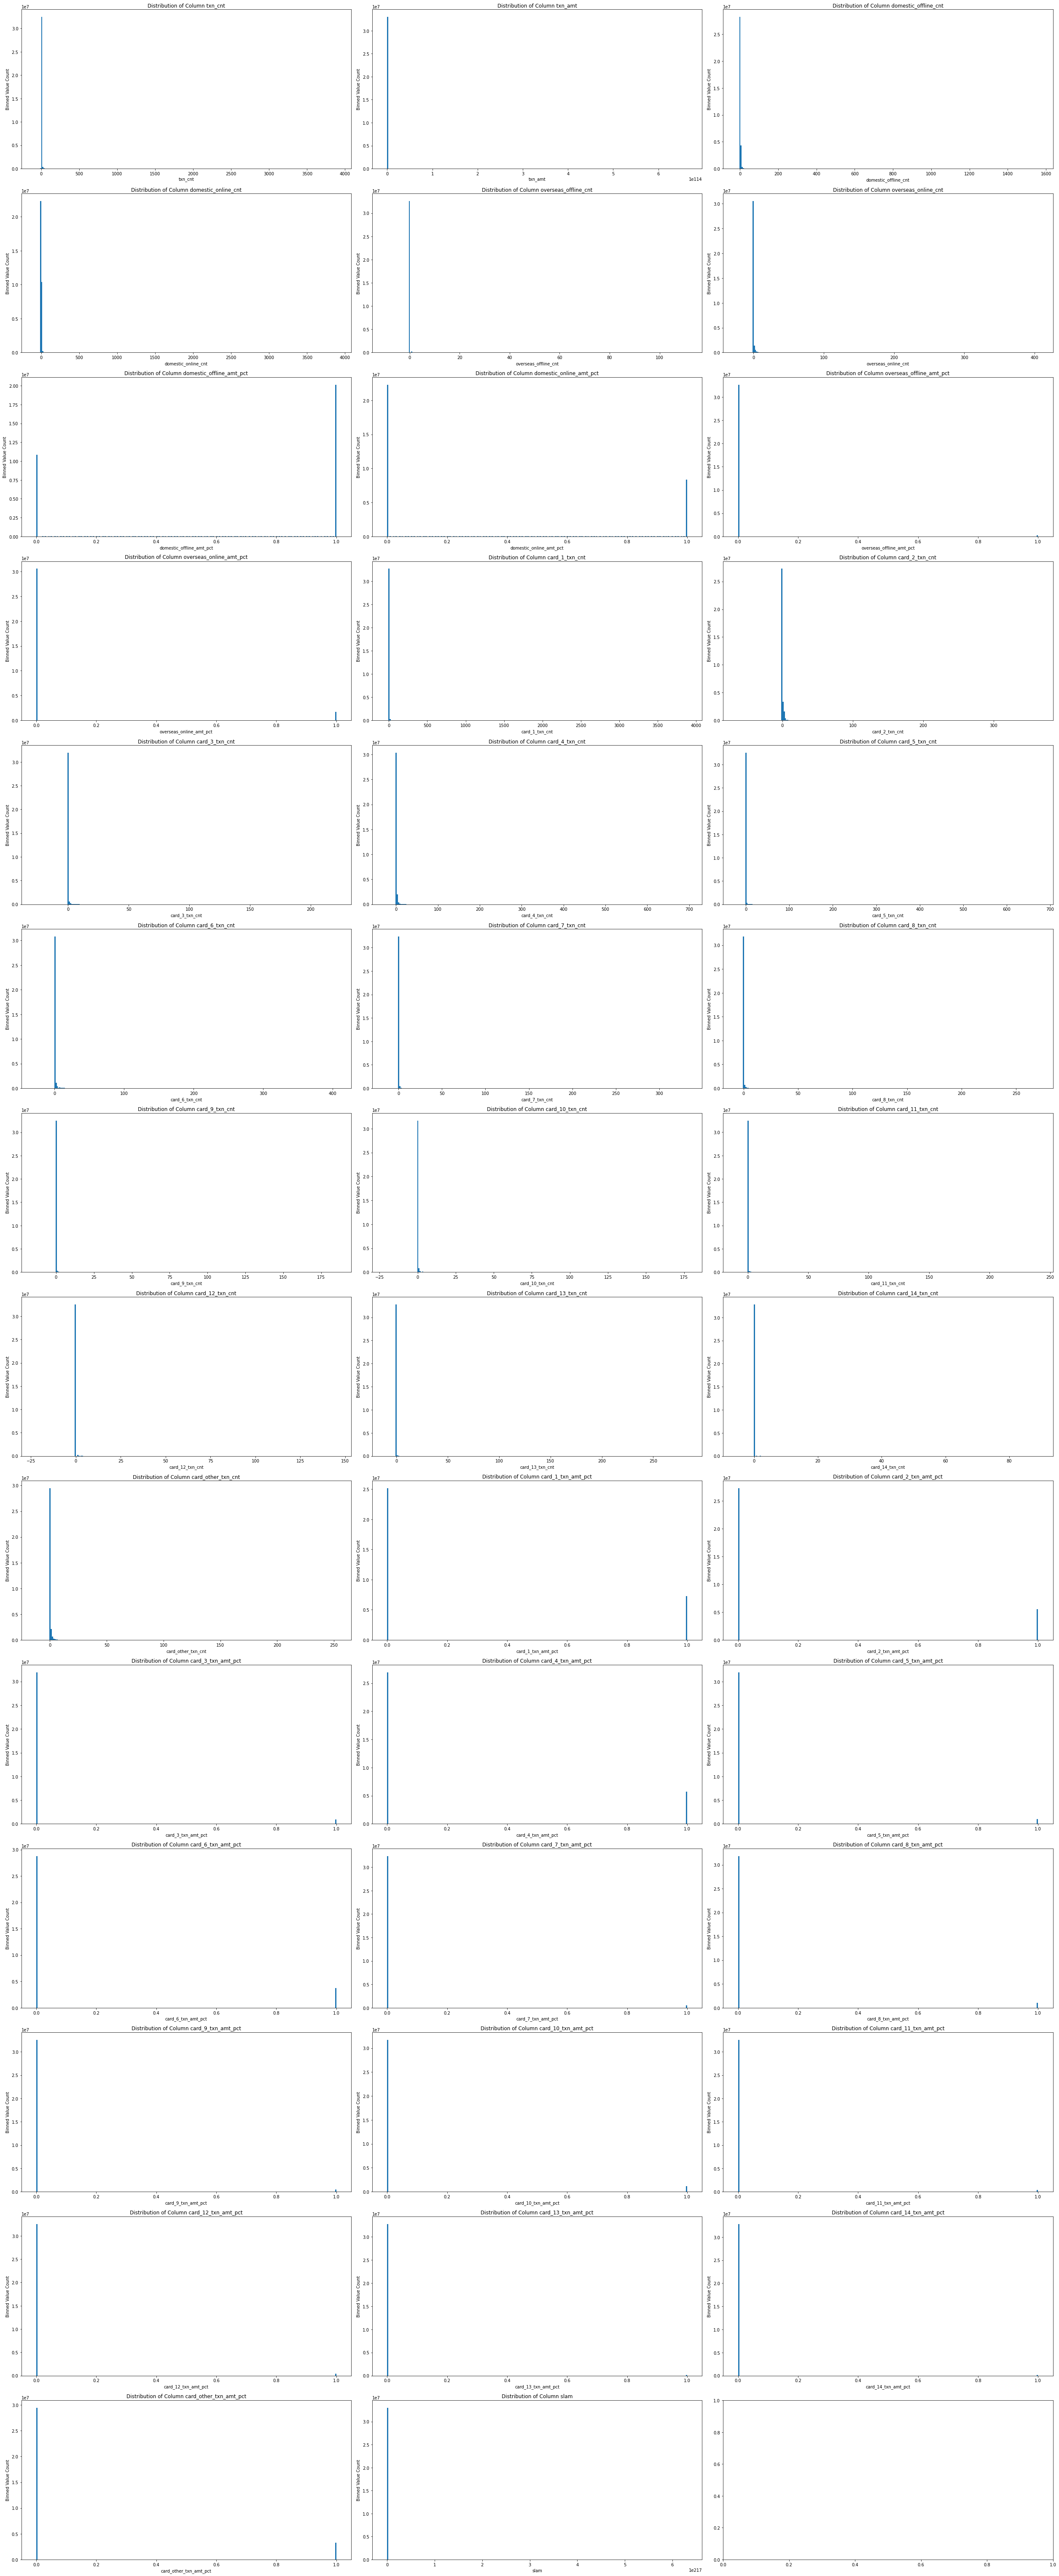

In [9]:
# 1.b Display univariate distribution for continuous variables using histogram
plot_hist(CONT_VARS)

In [8]:
# 2. Show upper and lower bounds of each continuous variable
with open("./feat_bounds.json", "r") as f:
    feat_bounds = json.load(f)
for f, bounds in feat_bounds.items():
    if f in CONT_VARS:
        n_neg_vals = np.sum(df[f] < 0)
        alert_prefix = '(V) ' if n_neg_vals > 0 else ''
        print(f"{alert_prefix}{f} | Upper bound {bounds['max']} | Lower bound {bounds['min']}" 
              f"| Samples with neg values {n_neg_vals}")

(V) txn_cnt | Upper bound 3884.0 | Lower bound -63.0| Samples with neg values 4327
txn_amt | Upper bound inf | Lower bound 22.370851516723633| Samples with neg values 0
(V) domestic_offline_cnt | Upper bound 1558.0 | Lower bound -10.0| Samples with neg values 1054
(V) domestic_online_cnt | Upper bound 3884.0 | Lower bound -63.0| Samples with neg values 2758
(V) overseas_offline_cnt | Upper bound 111.0 | Lower bound -9.0| Samples with neg values 200
(V) overseas_online_cnt | Upper bound 405.0 | Lower bound -22.0| Samples with neg values 1427
domestic_offline_amt_pct | Upper bound 1.0 | Lower bound 0.0| Samples with neg values 0
domestic_online_amt_pct | Upper bound 1.0 | Lower bound 0.0| Samples with neg values 0
overseas_offline_amt_pct | Upper bound 1.0 | Lower bound 0.0| Samples with neg values 0
overseas_online_amt_pct | Upper bound 1.0 | Lower bound 0.0| Samples with neg values 0
(V) card_1_txn_cnt | Upper bound 3884.0 | Lower bound -22.0| Samples with neg values 1011
(V) card_2_tx

In [ ]:
def plot_box(title, props):
    '''Plot box plot for each continuous value to observe detailed
    distribution properties (e.g., mean, 1st quarter, etc)
    
    Parameters:
        title: str, title of the plot
        props: dict, properties to apply on the plot, including  
            cols: list, names of features to plot
            show_mean: bool, whether to show the mean
            show_fliers: bool, whether to show outliers
            
    Return:
        None
    '''
    fig, ax = plt.subplots(figsize=(14, 7))
    cols = props['cols']
    ax.boxplot(df[cols], notch=True, showmeans=props['show_mean'], showfliers=props['show_fliers'])
    ax.set_xticks(ticks=range(1, len(cols)+1))
    ax.set_xticklabels(labels=cols, rotation=90)
    ax.set_xlabel("Feature Name")
    ax.set_ylabel("Value")
    ax.set_title(title)
    plt.show()

In [ ]:
# 3. Display boxplots to interpret value distribution from different perspective
cont_var_groups = {
    'Transaction Count': {
        'cols': [col for col in COLS if col.endswith('cnt')],
        'show_mean': True, 'show_fliers': True
    },
    'Transaction Amount Percentage': {
        'cols': [col for col in COLS if col.endswith('amt_pct')],
        'show_mean': True, 'show_fliers': True
    }, 
    'Transaction Amount and Slam': {
        'cols': ['txn_amt', 'slam'],
        'show_mean': False, 'show_fliers': True
    }
}
for title, props in cont_var_groups.items():
    plot_box(title, props)

In [6]:
# 4. Show ratios of zero values of continuous variables
df_zero_ratios = pd.DataFrame(columns=['feature', 'zero_ratio'])
for col in CONT_VARS:
    series = df[col]
    zero_ratio = { 
        'feature': col,
        'zero_ratio': (series == 0).sum() / N_SAMPLES
    }
    df_zero_ratios = df_zero_ratios.append(zero_ratio, ignore_index=True)
    del series
df_zero_ratios.sort_values(by=['zero_ratio'], ascending=False, inplace=True)
df_zero_ratios.T

,23,38,22,37,4,8,21,36,18,33,20,35,16,31,14,29,12,27,17,32,19,34,9,5,24,39,15,30,11,26,13,28,10,25,3,7,2,6,40,0,1
feature,card_14_txn_cnt,card_14_txn_amt_pct,card_13_txn_cnt,card_13_txn_amt_pct,overseas_offline_cnt,overseas_offline_amt_pct,card_12_txn_cnt,card_12_txn_amt_pct,card_9_txn_cnt,card_9_txn_amt_pct,card_11_txn_cnt,card_11_txn_amt_pct,card_7_txn_cnt,card_7_txn_amt_pct,card_5_txn_cnt,card_5_txn_amt_pct,card_3_txn_cnt,card_3_txn_amt_pct,card_8_txn_cnt,card_8_txn_amt_pct,card_10_txn_cnt,card_10_txn_amt_pct,overseas_online_amt_pct,overseas_online_cnt,card_other_txn_cnt,card_other_txn_amt_pct,card_6_txn_cnt,card_6_txn_amt_pct,card_2_txn_cnt,card_2_txn_amt_pct,card_4_txn_cnt,card_4_txn_amt_pct,card_1_txn_cnt,card_1_txn_amt_pct,domestic_online_cnt,domestic_online_amt_pct,domestic_offline_cnt,domestic_offline_amt_pct,slam,txn_cnt,txn_amt
zero_ratio,0.99529,0.995281,0.99438,0.994359,0.9892,0.989199,0.986759,0.986731,0.986271,0.986231,0.985949,0.985931,0.981017,0.980985,0.969041,0.968985,0.968922,0.968843,0.964519,0.964479,0.960937,0.960882,0.926737,0.926725,0.892597,0.89242,0.872408,0.872008,0.827566,0.82718,0.817083,0.816714,0.762479,0.762092,0.676799,0.675423,0.328627,0.327867,0.053067,0.002242,0.0


In [15]:
# 5. Check if there's any column with NaN value left
assert not df.isna().any().any()

In [7]:
df = pd.read_parquet("./data/raw/raw_data.parquet", columns=['dt', 'chid', 'shop_tag', 'txn_cnt', 'txn_amt'])
df.head()

,dt,chid,shop_tag,txn_cnt,txn_amt
0,1,10321418,45,3,3891.965283
1,1,10414574,15,2,10616.561549
2,1,10134567,48,2,23527.655416
3,1,10001003,48,9,17751.558260
4,1,10267183,2,1,21701.307598


In [3]:
def plot_dt_shop_tag_hmap(chid, feat):
    '''Plot heatmap indicating the intensity of feature values based on
    each (`dt`, `shop_tag`) entry.
    
    Parameters:
        chid: int, client identifier
        feat: str, name of feature to plot 
    
    Return:
        None
    '''
    df_ = df[df['chid'] == chid].loc[:, ['dt', 'shop_tag', feat]]
    feat_vals = np.zeros((len(SHOP_TAGS), len(DTS)))
    for i, r in df_.iterrows():
        shop_tag = int(r['shop_tag'])
        dt = int(r['dt'])
        feat_vals[-shop_tag][dt-1] = r[feat].round(1)
        
    fig, ax = plt.subplots(figsize=(14, 28))
    hmap = ax.imshow(feat_vals)
    ax.set_xticks(np.arange(len(DTS)))
    ax.set_yticks(np.arange(len(SHOP_TAGS)))
    ax.set_xticklabels(DTS, rotation=45)
    ax.set_yticklabels(SHOP_TAGS)
    for i in range(len(SHOP_TAGS)):
        for j in range(len(DTS)):
            text = ax.text(j, len(SHOP_TAGS)-1-i, feat_vals[len(SHOP_TAGS)-1-i][j],
                           ha="center", va="center", color="w")
    ax.set_title(f"Feature Hmap of Client {chid}")
    fig.tight_layout()
    plt.show()

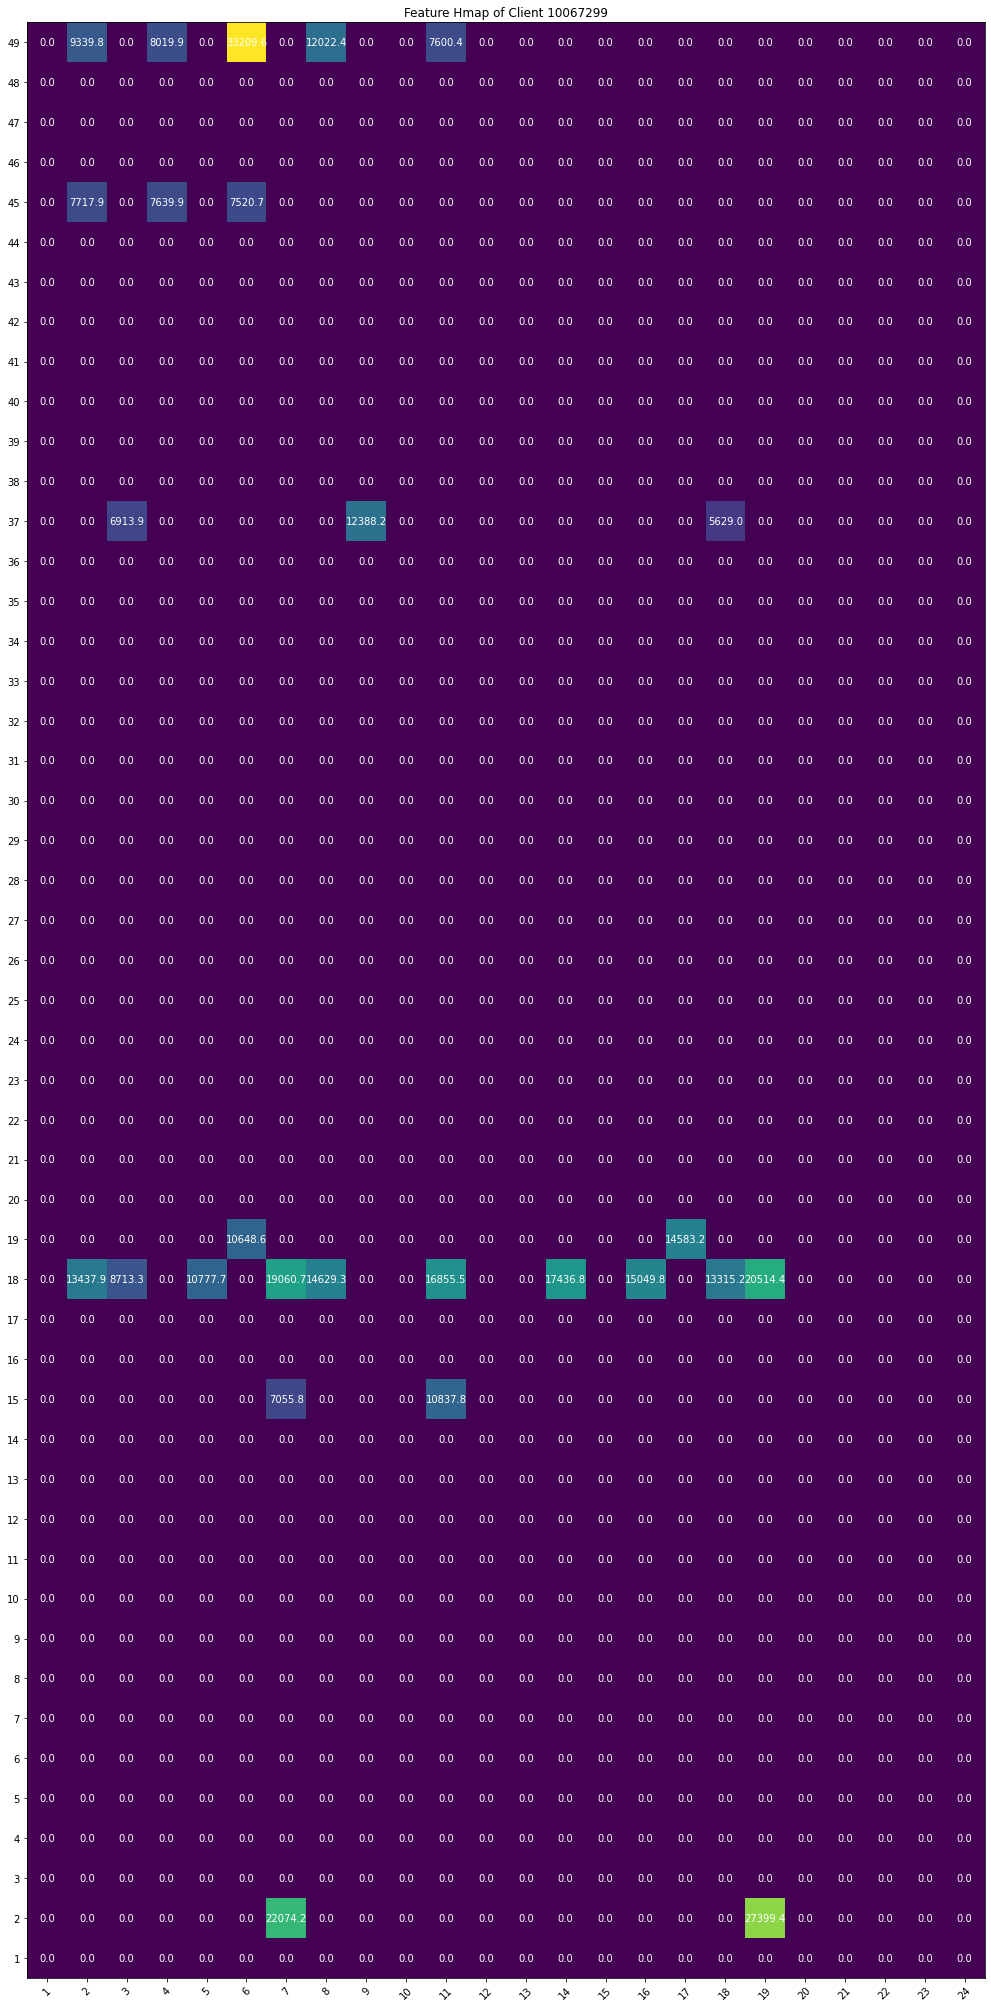

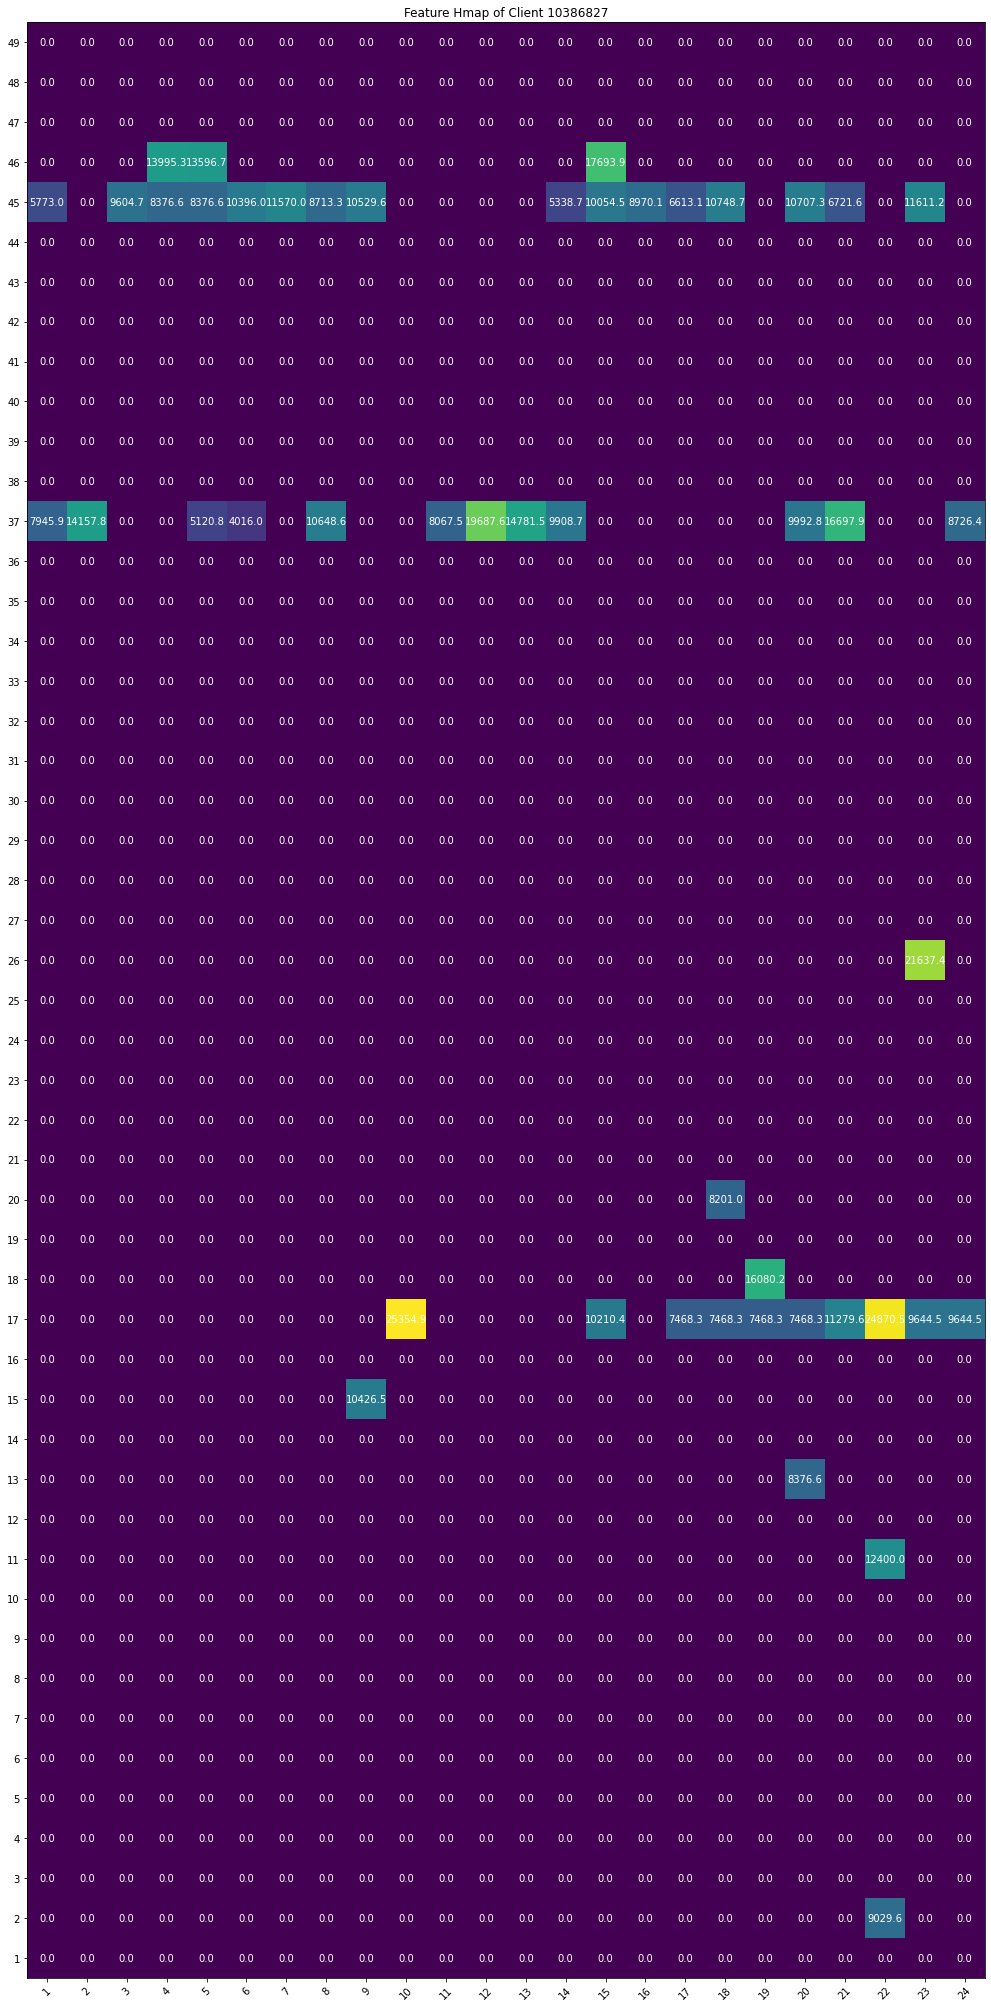

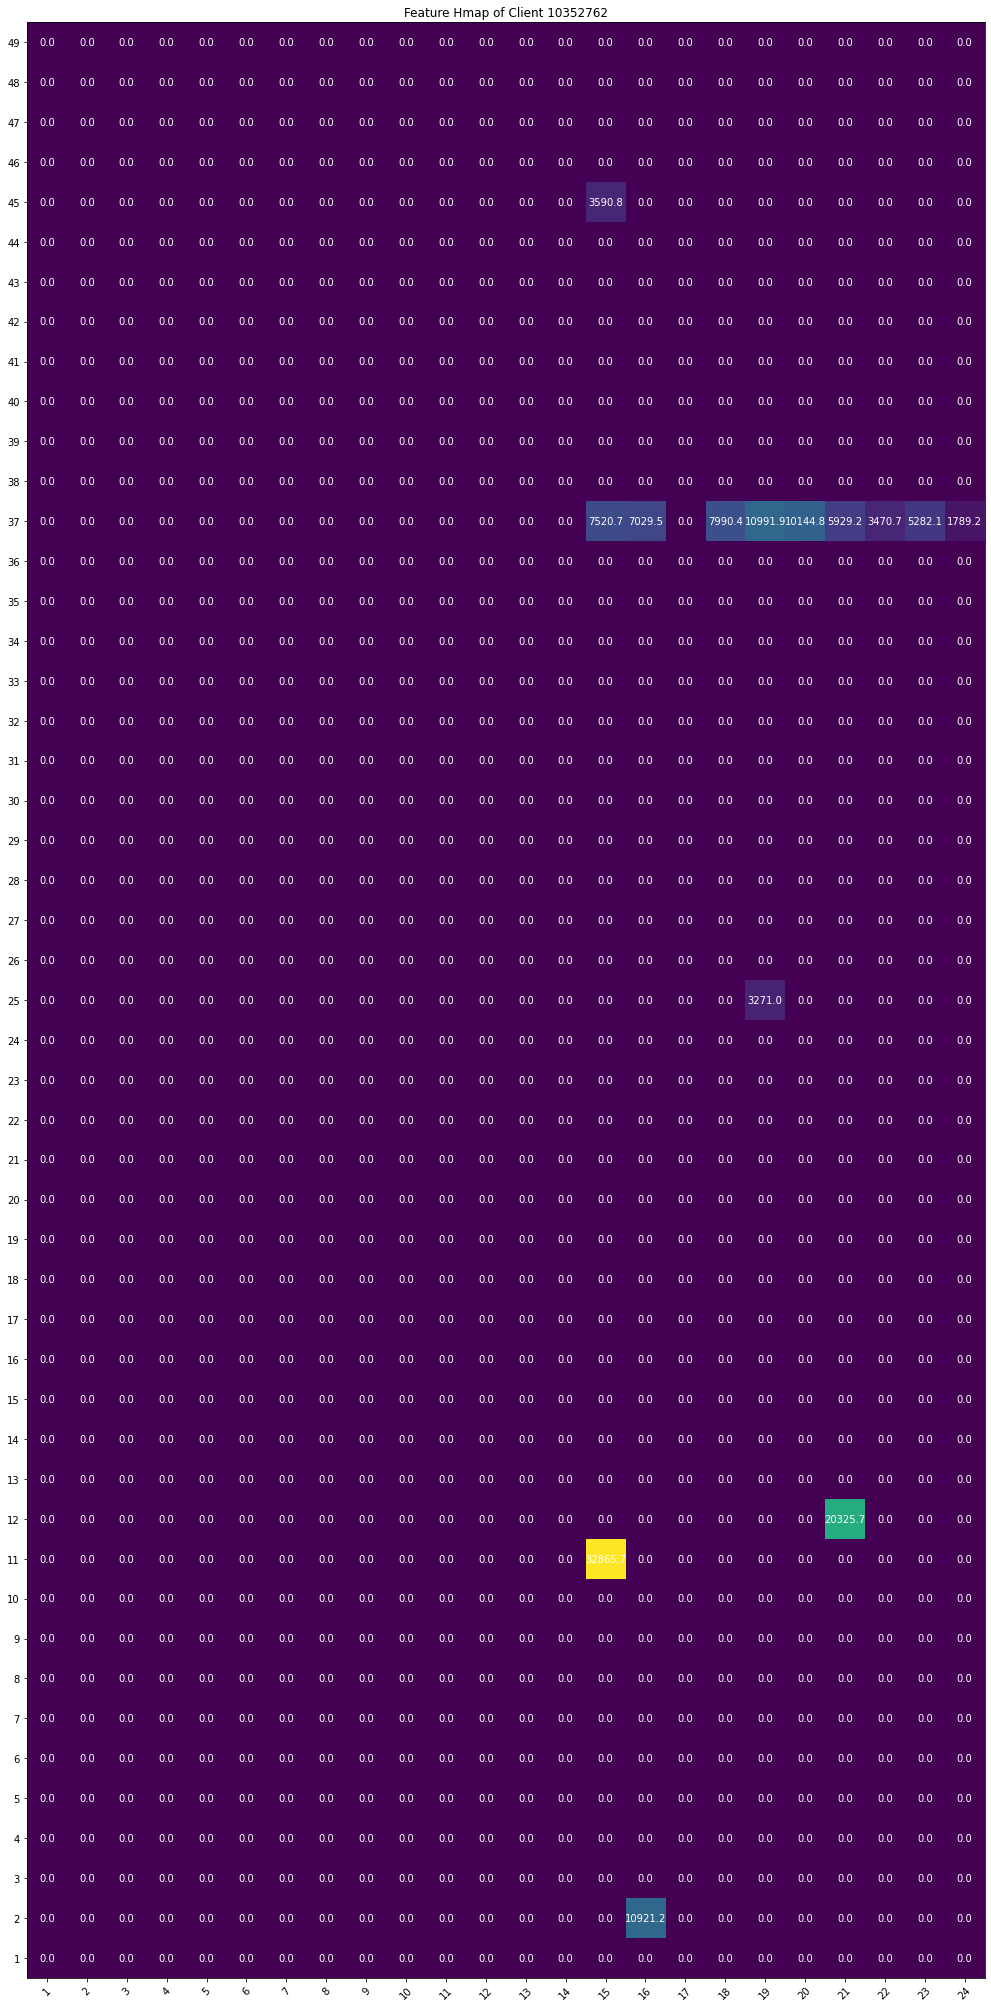

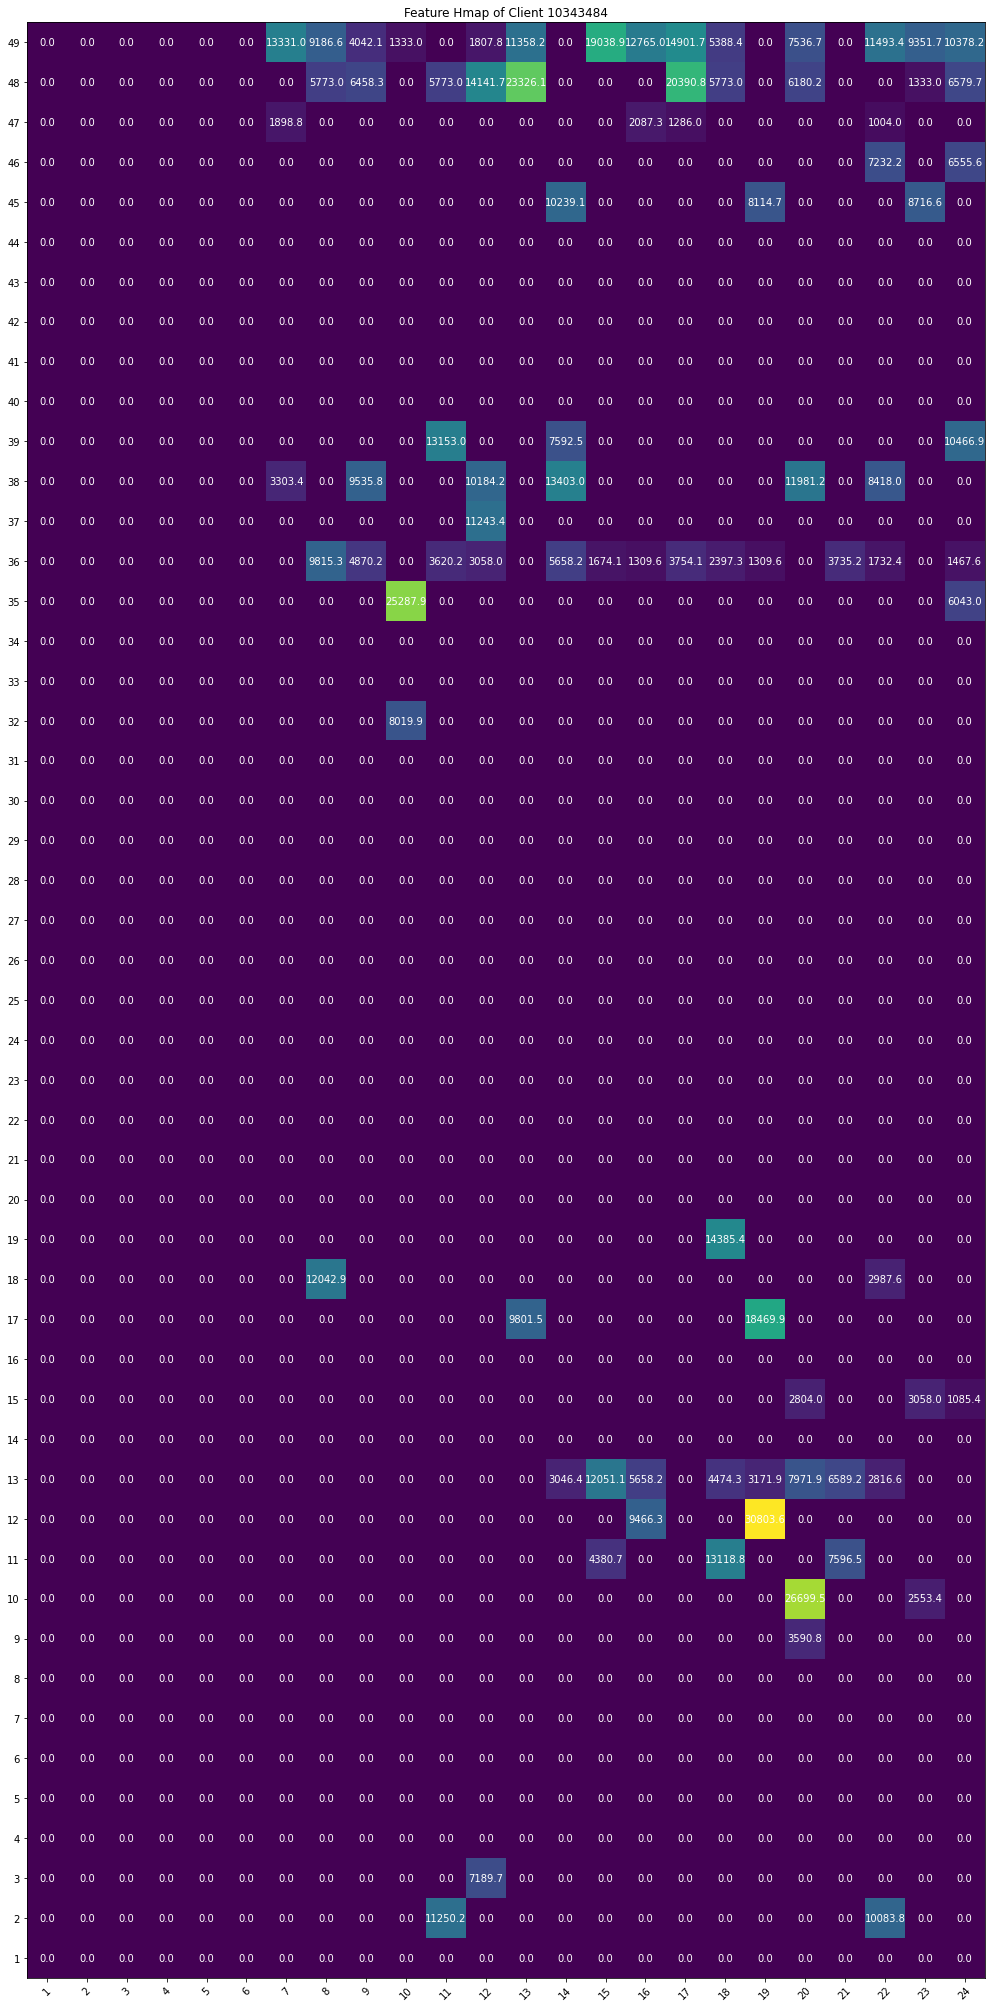

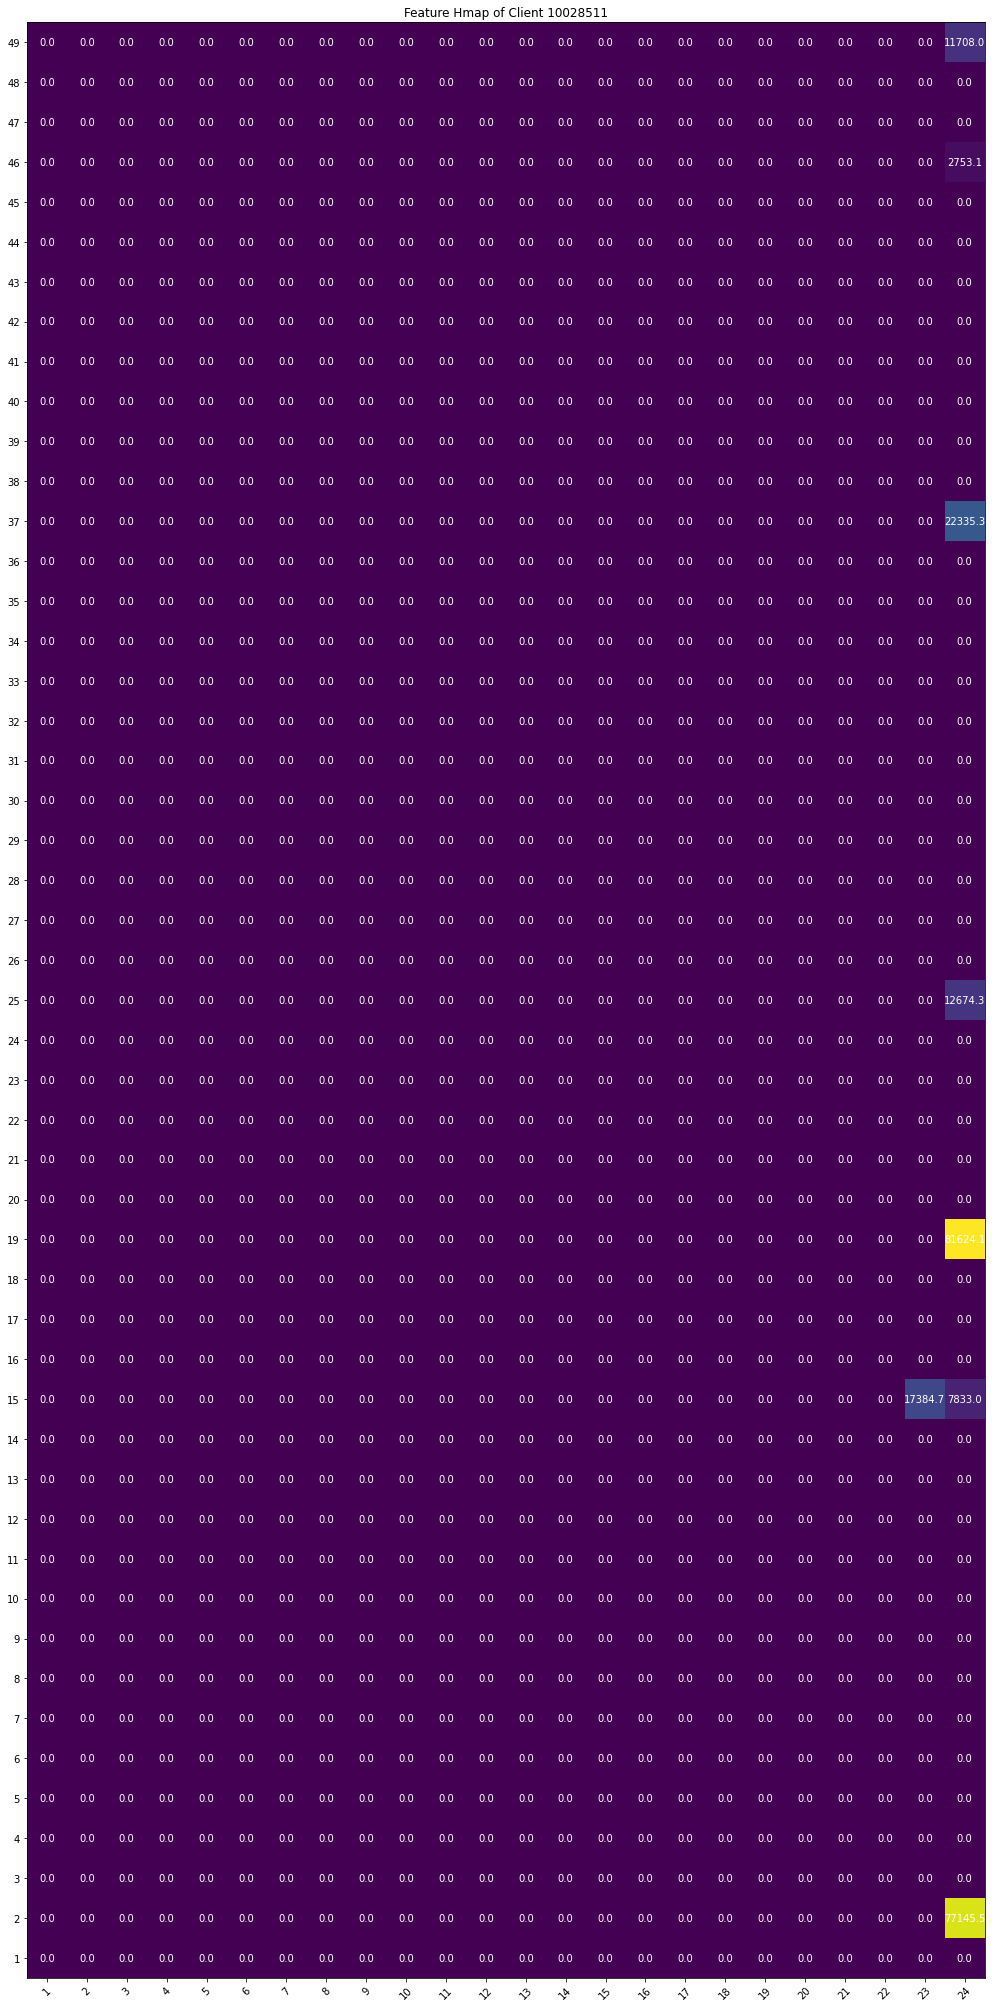

In [5]:
# 6. Check if the specified patterns have some special patterns
# either spatial (i.e., between shop_tags) or temporal
chids = sample(list(df['chid'].unique()), 5)
for chid in chids:
    plot_dt_shop_tag_hmap(chid, 'txn_amt')

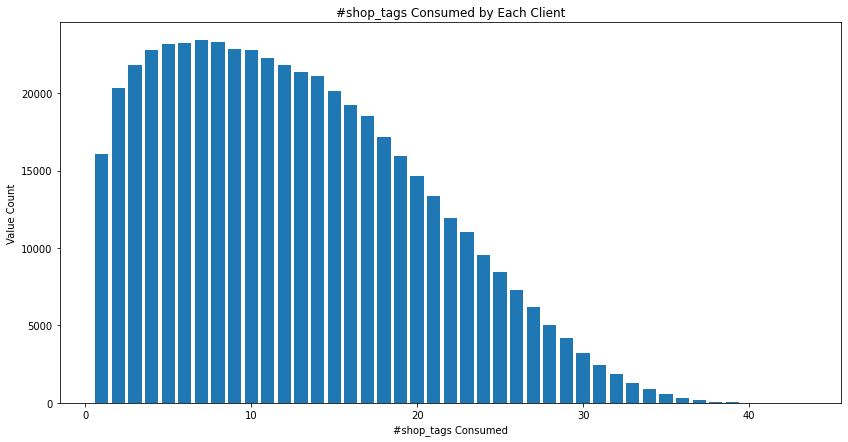

In [23]:
# 7. Check number of shop_tags every client has consumed so far;
# that is, those having been consumed by the client in the past
n_shop_tags = df.groupby(by=['chid'])['shop_tag'].nunique()
n_shop_tag_counts = n_shop_tags.value_counts()
n_shop_tag_counts.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(x=n_shop_tag_counts.index, height=n_shop_tag_counts.values)
ax.set_xlabel("#shop_tags Consumed")
ax.set_ylabel("Value Count")
ax.set_title("#shop_tags Consumed by Each Client")
plt.show()

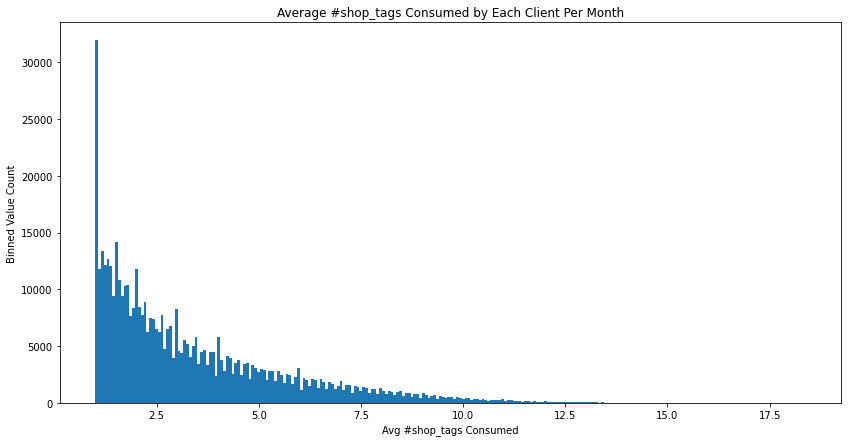

In [35]:
# 8. Check average number of shop_tags every client consumed per month
avg_shop_tags = df.groupby(by=['chid', 'dt'], 
                           sort=False)['shop_tag'].nunique()
chid = avg_shop_tags.index.droplevel('dt')
avg_shop_tags = pd.DataFrame(avg_shop_tags.values, 
                             index=chid,
                             columns=['n_shop_tags'])
avg_shop_tags = avg_shop_tags.groupby(by=avg_shop_tags.index,
                                      sort=True)['n_shop_tags'].mean()

fig, ax = plt.subplots(figsize=(14, 7))
ax.hist(x=avg_shop_tags, bins=250)
ax.set_title(f"Average #shop_tags Consumed by Each Client Per Month")
ax.set_xlabel(f"Avg #shop_tags Consumed")
ax.set_ylabel("Binned Value Count")
plt.show()

In [32]:
# 9. Analyze quantiles of average #shop_tags consumed by each client per month
qs, qvs = [], []
for q in np.arange(0.1, 1, 0.1):
    qs.append(int(q*100))
    qvs.append(n_shop_tags_avg_per_month.quantile(q).round(2))
print(f"=====Quantiles of Avg #shop_tags Consumed (from 10% ~ 90% Quantiles)=====")
print(qs)
print(qvs)
print(f"Minimum: {n_shop_tags_avg_per_month.quantile(0)} | Maximum {n_shop_tags_avg_per_month.quantile(1)}")
print(f"Nearly {np.sum(n_shop_tags_avg_per_month <= 10) / 500000 * 100:.2f}% of avg #shop_tags consumed is less or equal to 10.")

=====Quantiles of Avg #shop_tags Consumed (from 10% ~ 90% Quantiles)=====
[10, 20, 30, 40, 50, 60, 70, 80, 90]
[1.17, 1.46, 1.78, 2.17, 2.65, 3.26, 4.04, 5.14, 6.8]
Minimum: 1.0 | Maximum 18.375
Nearly 98.36% of avg #shop_tags consumed is less or equal to 10.


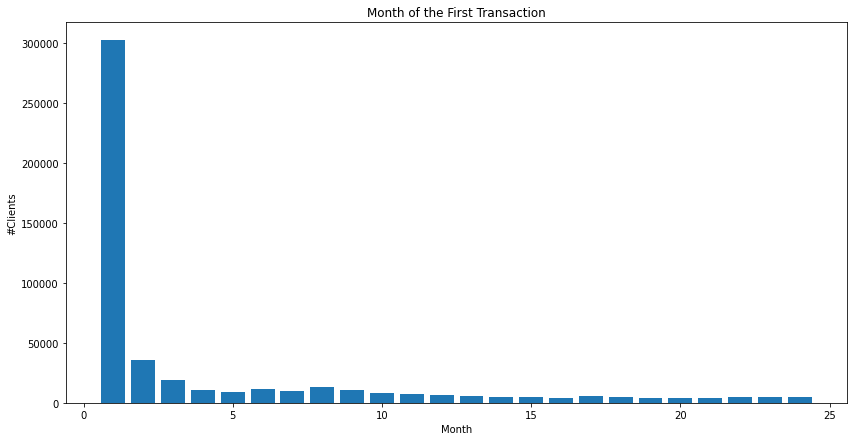

In [10]:
# 10. Display the time point of each client's first consumption 
dts, dts_first_txn = np.unique(chid_gps['dt'].min(), return_counts=True)
fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(x=dts, height=dts_first_txn)
ax.set_title(f"Month of the First Transaction")
ax.set_xlabel("Month")
ax.set_ylabel("#Clients")
plt.show()

## b. Multivariate Analysis
In the second part, I take feature interaction into consideration, meaning that the analysis is based on more than one single feature. With this analysis, we can dig deeper into the underlying data behavior, and try to find out if there are some unreasonable conditions among the data.

### `(cnt, amt)` Pairs
Because each tranaction count corresponds to a transaction amount, I think there might be some situations that the correspondence fails.
#### Analysis and Observation
1. There are 9907490 samples with `(cnt, amt)` not aligned. That is, either the following situations occurs:
    * Transaction count is zero, but amount isn't.
    * Transaction count isn't zero, but amount is.

> The first situation above is reasonable due to the occurrence of **returning consumption for refund**.

<div class='alert alert-warning'>
    <p>
    <strong>(Solved)</strong> 2. There are 30137 samples with <strong>unreasonable</strong> <code>(cnt, amt)</code> pairs. That is, the second situation described above occurs.
    </p>
</div>

In [3]:
# Check if transaction amount and transaction count are aligned;
# that is, if one of them is zero, how about the other one 
def check_cnt_amt_aligned(sub_df):
    '''Check if (cnt, amt) pairs are aligned or not.
    *Note: This function is designed for subset of raw data to save mem.
    
    Parameters:
        sub_df: pd.DataFrame, subset of raw data 
    
    Return:
        aligned: ndarray, numbers of non-aligned (cnt, amt) pairs per sample
    '''
    sub_df_cnt = sub_df[cols_cnt].astype(bool).to_numpy()
    sub_df_amt = sub_df[cols_amt].astype(bool).to_numpy()
    aligned = np.sum(np.logical_xor(sub_df_cnt, sub_df_amt), axis=1)
    
    return aligned
    
cols_cnt = [col for col in COLS if col.endswith('cnt')]
cols_amt = [col for col in COLS if col.endswith('pct') or col == 'txn_amt']
chid_not_aligned = [] 
for file in tqdm(os.listdir("./data/")):
    sub_df = pd.read_parquet(os.path.join("./data", file))
    sub_df['cnt_amt_aligned'] = check_cnt_amt_aligned(sub_df)
    chid_not_aligned += list(sub_df[sub_df['cnt_amt_aligned'] != 0]['chid'])
    
    del sub_df

100%|██████████| 330/330 [00:07<00:00, 43.94it/s]


In [13]:
# Analyze clients with (cnt, amt) not aligned
def check_cnt_amt_reasonable(df_not_aligned):
    '''Check if the non-alignment is reasonable or not.
    
    Parameters:
        df_not_aligned: pd.DataFrame, samples with non-aligned (cnt, amt)
    
    Return:
        reasonable: list, number of unreasonable (cnt, amt) pairs per sample
    '''
    df_not_aligned_cnt = df_not_aligned[cols_cnt].astype(bool).to_numpy()
    df_not_aligned_amt = df_not_aligned[cols_amt].astype(bool).to_numpy()
    reasonable = []
    for i in tqdm(range(df_not_aligned_cnt.shape[0])):
        reasonable_tmp = 0
        for j in range(df_not_aligned_cnt.shape[1]):
            if df_not_aligned_cnt[i][j] != 0 and df_not_aligned_amt[i][j] == 0:
                reasonable_tmp += 1
        reasonable.append(reasonable_tmp)
    return reasonable

df = pd.read_parquet("./raw_data.parquet")
df_not_aligned = df[df['chid'].isin(chid_not_aligned)]
del df 
gc.collect()
df_not_aligned['cnt_amt_reasonable'] = check_cnt_amt_reasonable(df_not_aligned)
df_unreasonable = df_not_aligned[df_not_aligned['cnt_amt_reasonable'] != 0]
print(f"#Samples with (cnt, amt) pairs not aligned: {len(df_not_aligned)}\n"
      f"#Samples with unreasonable (cnt, amt) pairs: {len(df_unreasonable)}")

#Clients with (cnt, amt) pairs not aligned: 9907490
#Clients with unreasonable (cnt, amt) pairs: 30137


### `primary_card` Interpretation
If one client make transactions with more than one card on the same consumption category in one month. How to interpret `primary_card`?
#### Analysis and Observation
<div class='alert alert-warning'>
    <p>
    <strong>(Solved)</strong> 1. There are 1249538 samples with transaction card counts not equal to one. And I don't know how to interpret <code>primary card</code>. Notice that I explore this phenomenon using <code>card_x_txn_cnt</code> which might lead to some missing transactions if there exists any <strong>return for refund</strong>.
     </p>
</div>

In [11]:
# Check 'primary_card' behavior of those samples with more than one
# card having non-zero transaction counts
def count_txn_cards(sub_df):
    '''Count number of cards used in each sample.
    
    Parameters:
        sub_df: pd.DataFrame, subset of raw data 
        
    Return:
        card_counts: list, number of cards used per sample
    '''
    sub_df_card_txn_cnt = sub_df[cols_card_txn_cnt].astype(bool).to_numpy()
    card_counts = list(np.sum(sub_df_card_txn_cnt, axis=1))
    
    return card_counts

cols_card_txn_cnt = [col for col in COLS if col.startswith('card') and col.endswith('txn_cnt')] 
txn_cards = []
for file in tqdm(FILE_ORDERED):
    sub_df = pd.read_parquet(os.path.join("./data", file))
    txn_cards += count_txn_cards(sub_df)
    
    del sub_df
    
df = pd.read_parquet("./raw_data.parquet")
df['txn_cards'] = txn_cards
df_ = df[df['txn_cards'] != 1]
print(f"#Samples making transactions with more than one card: {len(df_)}")

#Samples making transactions with more than one card: 1249538


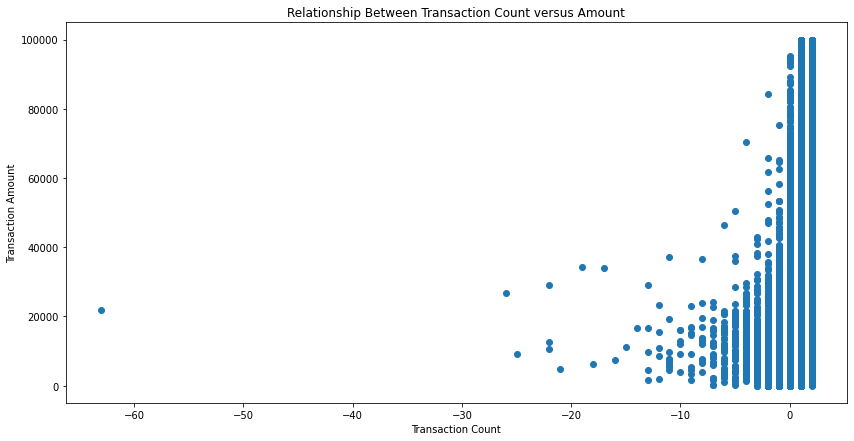

In [20]:
# Display the relationship between transaction count and amount to check if there's
# any behavior like positive correlation (notice value threshold is enforced to 
# facilitate visualization)
txn_amt_thres = 1e5
txn_cnt_thres = 3
txn_info = df.loc[:, ['txn_amt', 'txn_cnt']]
txn_info = txn_info[txn_info['txn_amt'] < txn_amt_thres]
txn_info = txn_info[txn_info['txn_cnt'] < txn_cnt_thres]

fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(x=txn_info['txn_cnt'], y=txn_info['txn_amt'])
ax.set_xlabel("Transaction Count")
ax.set_ylabel("Transaction Amount")
ax.set_title("Relationship Between Transaction Count versus Amount")
plt.show()

### Spatial-Temporal - `PIF` Analysis
The main idea comes from [Modeling Personalized Item Frequency Information forNext-basket Recommendation](https://dl.acm.org/doi/pdf/10.1145/3397271.3401066). Namely, this is the analysis of **personalized item frequency**, from which I can understand if this specific dataset follows the statement in the paper. Notice that I randomly sample a subset of clients to speed up the process. And, the clients (~2000 out of 15000 samples) having no next baskets (i.e., |T|=0) are excluded.
#### Analysis and Observation
1. Nearly 90 % items in the next baskets can be captured by either **repeated purchases pattern** (client-specific)
2. Nearly 100 % items in the next baskets can be captured by either **collaborative purchases pattern**.
3. Neighbors seem to have a better capturing capability. Actually, I think it's because #`shop_tag`s is rather small compared to other benchmark datasets. Hence, after aggregating the baskets from neighbors, it's easy to hit items in the **next target basket**.
4. Nearly all of the items in the next baskets can be capture by either of them (i.e., ~0% not captured, see recall_NP_NN).

In [3]:
df = pd.read_parquet("./raw_data.parquet", columns=['dt', 'chid', 'shop_tag'])
df.sort_values(by=['chid', 'dt', 'shop_tag'], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,dt,chid,shop_tag
0,1,10000000,10
1,1,10000000,12
2,2,10000000,46
3,3,10000000,10
4,4,10000000,10


In [3]:
def get_purch_vec(chid_dt_gp):
    '''Return purchasing vector of one client for one month.
    
    Parameter:
        chid_dt_gp: pd.DataFrame, purchasing record of one client for 
                    one month
    
    Return:
        purch_vec: ndarray, purchasing vector indicating purchasing the 
                   shop_tag or not (i.e., represented by 0/1)
    '''
    purch_vec = np.zeros(49, dtype=np.int8)
    purch_vec[chid_dt_gp['shop_tag'].values-1] = 1
    
    return purch_vec
    
def get_purch_map(chid_gp):
    '''Return purchasing map of one client (including all months).
    
    Parameter:
        chid_dt_gp: pd.DataFrame, purchasing record of one client
    
    Return:
        purch_map: ndarray, purchasing map indicating purchasing the 
                   shop_tag or not (i.e., represented by 0/1)
    '''
    purch_map = chid_gp.groupby(by=['dt']).apply(get_purch_vec)
    empty_dts = [dt-1 for dt in DT_INDICES 
                 if dt not in purch_map.index]   # -1 to align with insertion idx
    purch_map = purch_map.values   # Shape (24, )
    purch_map = np.vstack(purch_map)
    # Insert empty basket index by index, becasuse inserting all at once leads to 
    # undesired results, for more information, see np.insert
    for empty_dt in empty_dts:
        purch_map = np.insert(purch_map, obj=empty_dt, values=EMPTY_BASKET, axis=0)
    
    return purch_map

def get_pif(purch_map, t1, t2):
    '''Return personalized item frequency computed from the given time
    interval.
    
    Parameters:
        purch_map: ndarray, purchasing map indicating purchasing the 
                   shop_tag or not (i.e., represented by 0/1)
        t1: int, time lower bound
        t2: int, time upper bound
    
    Return:
        pif: ndarray, personalized item frequency vector
    '''
    # Align with array index
    purch_map = purch_map[t1:t2]
    pif = np.sum(purch_map, axis=0)
    return pif

In [ ]:
# Generate and dump purchasing maps
chid_gps = df.groupby(by=['chid'])
DT_INDICES = [t+1 for t in range(N_MONTHS)]
EMPTY_BASKET = np.zeros(N_SHOP_TAGS, dtype=np.int8)
purch_maps = {}
for chid_gp_name, chid_gp in tqdm(chid_gps):
    purch_maps[chid_gp_name] = get_purch_map(chid_gp)

with open("./purch_maps.pkl", 'wb') as f:
    pickle.dump(purch_maps, f)

In [4]:
# Generate pif and target baskets for further importance analysis
with open("./purch_maps.pkl", 'rb') as f:
    purch_maps = pickle.load(f)
pifs = {}
t_start, t_end = 0, 23   # Notice that t_end is excluded

for chid, purch_map in tqdm(purch_maps.items()):   
    pifs[chid] = get_pif(purch_map, t1=t_start, t2=t_end)
target_baskets = {chid: purch_map[-1] for chid, purch_map in purch_maps.items()}

100%|██████████| 500000/500000 [00:02<00:00, 179629.98it/s]


In [7]:
# Analyze importances of two patterns behind pif
cosine_sim = lambda v1, v2: np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))
recall_P, recall_N, recall_P_N, recall_NP_NN = 0, 0, 0, 0 
n_neighbors = 50
n_chid_samples = 15000
n_chid_no_next_basket = 0
chid_samples = sample(purch_maps.keys(), n_chid_samples)

for chid in tqdm(chid_samples):
    sim_vecs = {}
    P, T = pifs[chid], target_baskets[chid]
    neighbor_candidates = sample(purch_maps.keys(), 500)
    
    for chid_ in neighbor_candidates:
        if chid == chid_: continue
        neighbor = pifs[chid_]
        sim_vecs[chid_] = cosine_sim(T, neighbor)
    sim_vecs = dict(sorted(sim_vecs.items(), 
                           key=lambda item: item[1], 
                           reverse=True))
    neighbors = list(sim_vecs.keys())[:n_neighbors]
    N = np.array([False for _ in range(N_SHOP_TAGS)])
    for n in neighbors:
        N = np.bitwise_or(N, pifs[n].astype(bool))
        if N.sum() == N_SHOP_TAGS:
            # If all shop_tags are included in the past baskets of neighbors
            break
    P, T = P.astype(bool), T.astype(bool)
    NP, NN = ~P, ~N
    if T.sum() == 0:
        n_chid_no_next_basket += 1
    else:
        recall_P += (P * T).sum() / T.sum() 
        recall_N += (N * T).sum() / T.sum()
        recall_P_N += (P * N * T).sum() / T.sum()
        recall_NP_NN += (NP * NN * T).sum() / T.sum()
    del T, sim_vecs, neighbor_candidates, neighbors

n_chid_valid = n_chid_samples - n_chid_no_next_basket
recall_P = recall_P / n_chid_valid
recall_N = recall_N / n_chid_valid
recall_P_N = recall_P_N / n_chid_valid
recall_NP_NN = recall_NP_NN / n_chid_valid
print("=====PIF Pattern Importance=====")
print(f"{n_chid_no_next_basket} has no next basket.")
print("{:>15}{:>15}{:>15}{:>15}".format('Recall_P', 'Recall_N', 'Recall_P_N', 'Recall_NP_NN'))
print("{:15}{:15}{:15}{:15}".format(recall_P.round(4), recall_N.round(4), recall_P_N.round(4), recall_NP_NN.round(4)))

100%|██████████| 15000/15000 [02:40<00:00, 93.44it/s]

=====PIF Pattern Importance=====
1933 has no next basket.
       Recall_P       Recall_N     Recall_P_N   Recall_NP_NN
         0.9013         0.9995         0.9009         0.0001


### Spatial-Temporal - Dynamic of `txn_cnt`
To observe the temporal patterns of transaction counts and the popularity of each `shop_tag`s, I decide to explore the **global transaction count patterns** using different visualzation methods.
#### Analysis and Observation 
1. The legitimate `shop_tag`s all have relatively high transaction counts, which are displayed as follows:<br>
[2, 6, 10, 12, 13, 15, 18, 19, 21, 22, 25, 26, 36, 37, 39, 48]
2. Peak months are clustered at closer months. One of the reason is that the number of clients participating in and starting the transactions increases with time, which can also be observed from the figure summing transaction counts over `shop_tag`s.

<div class='alert alert-block alert-warning'>
    <p>3. We can see that there are more transaction counts in some months compared with the neighbor months. Hence, I use <strong>seansonal decomposition</strong> to see if it can help me find out the correct month. Combined with some surveys, I guess that month id 24 is <i>September</i>.</p>
</div>

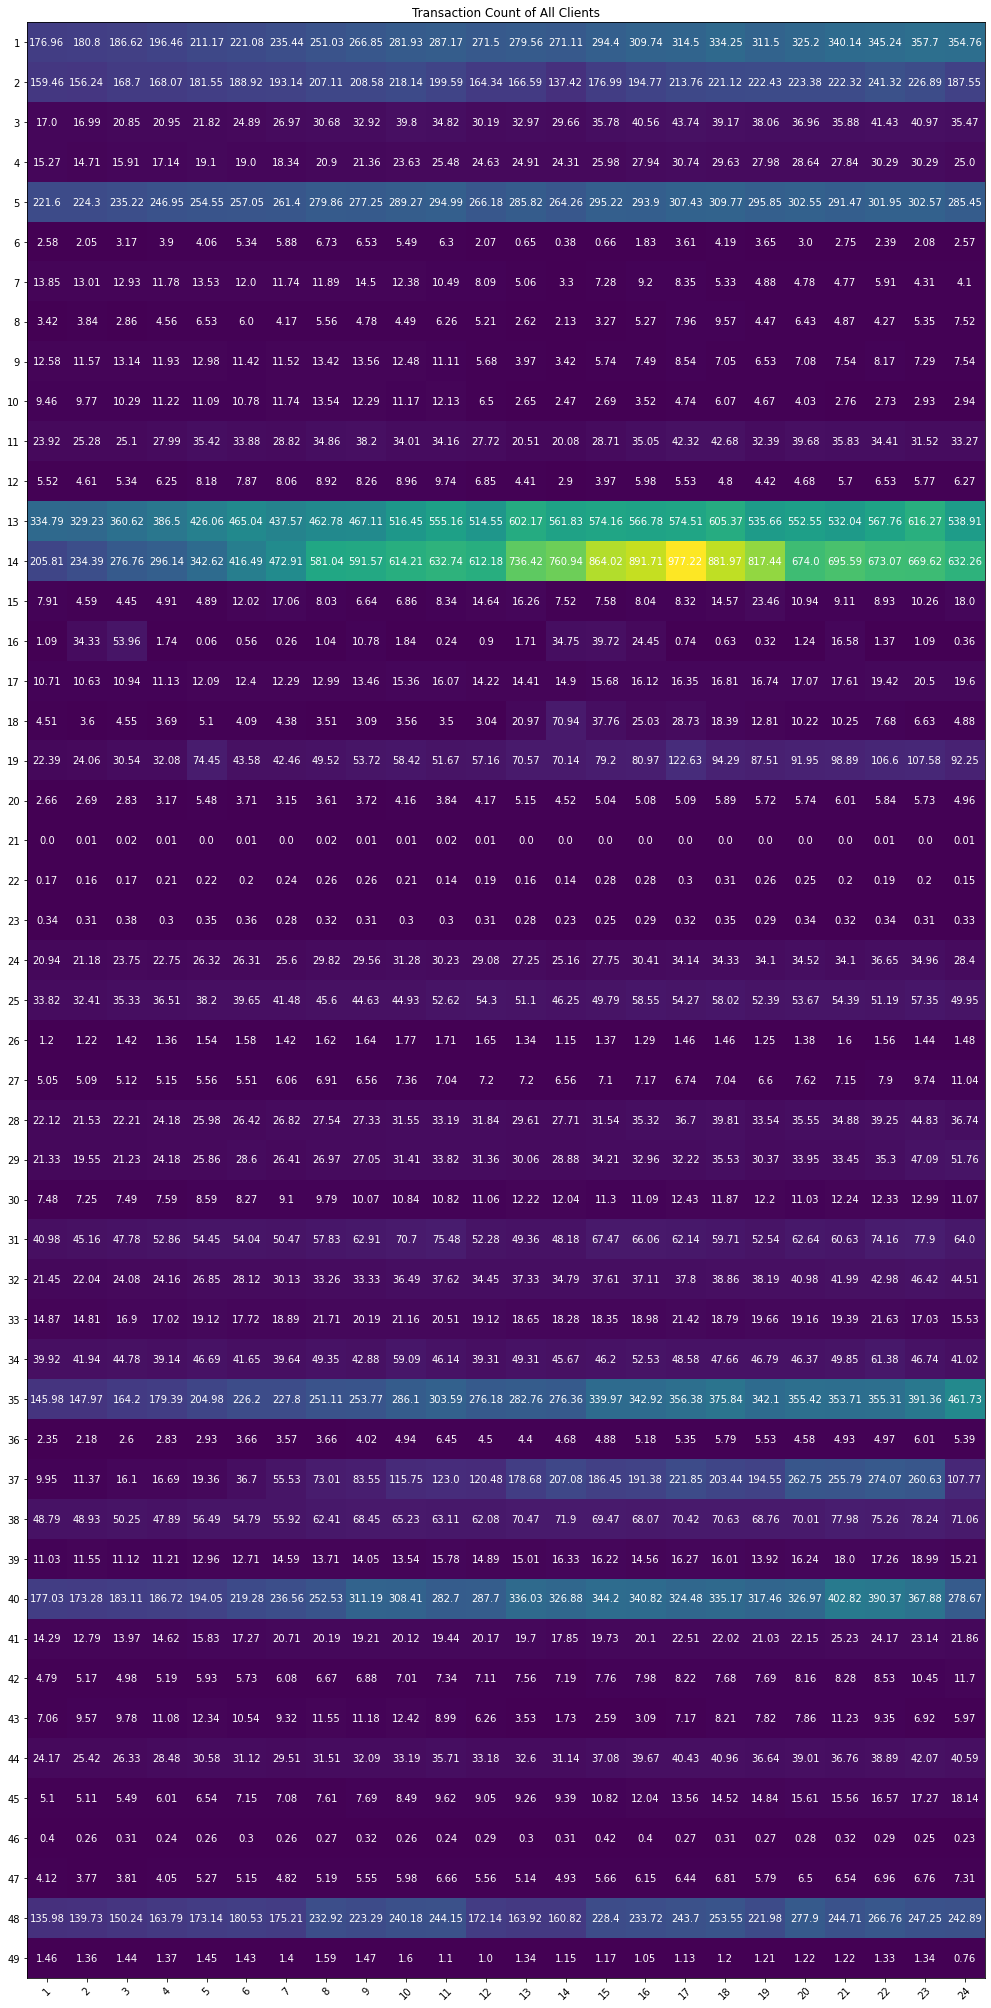

In [7]:
# Analyze transaction peaks using vanilla total transaction counts
# txn_cnt_map = get_txn_cnt_map(df, chid=None)
# with open("./data/processed/txn_cnt_map_global.npy", 'wb') as f:
#     np.save(f, txn_cnt_map_global)

# Load global transaction count map
with open("./data/processed/txn_cnt_map_global.npy", 'rb') as f:
    txn_cnt_map = np.load(f)
txn_cnt_map = np.round_(txn_cnt_map / 1000, decimals=2)   # Scale to facilitate visualization

fig, ax = plt.subplots(figsize=(20, 28))
hmap = ax.imshow(txn_cnt_map)
ax.set_xticks(np.arange(len(DTS)))
ax.set_yticks(np.arange(len(SHOP_TAGS)))
ax.set_xticklabels(DTS, rotation=45)
ax.set_yticklabels(SHOP_TAGS)
for i in range(len(SHOP_TAGS)):
    for j in range(len(DTS)):
        text = ax.text(j, len(SHOP_TAGS)-1-i, txn_cnt_map[len(SHOP_TAGS)-1-i][j],
                       ha="center", va="center", color="w")
ax.set_title(f"Transaction Count of All Clients")
fig.tight_layout()
plt.show()

Consumption peak months: 
[ 3  8  9 10 11 14 15 16 17 18 19 20 21 22 23 24]
[ 3  3  2  3  2  1  1  1  4  4  1  1  3  4 10  6]


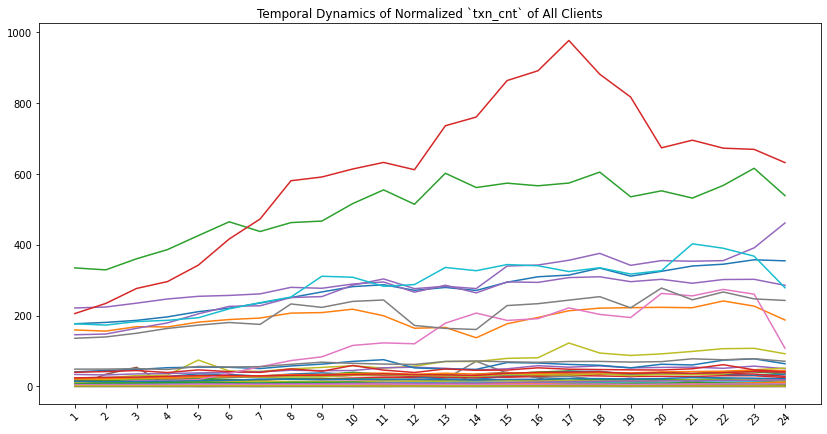

In [8]:
# Use line plot to show transaction count curve
# and counts of peak months are also shown
fig, ax = plt.subplots(figsize=(14, 7))
for shop_tag in SHOP_TAGS:
    ax.plot(txn_cnt_map[shop_tag-1, ])
ax.set_xticks(np.arange(len(DTS)))
ax.set_xticklabels(DTS, rotation=45)
ax.set_title(f"Temporal Dynamics of Normalized `txn_cnt` of All Clients")
fig.show()

peak_month = np.argmax(txn_cnt_map, axis=1) + 1
peak_months, peak_month_cnts = np.unique(peak_month, return_counts=True)
print(f"Consumption peak months: \n{peak_months}\n{peak_month_cnts}")

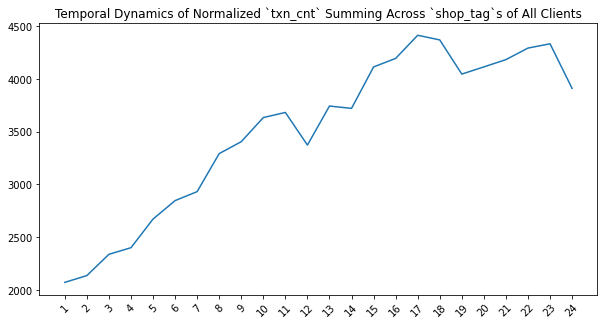

In [9]:
# Display transaction count at the global scale
# (i.e., summing over `shop_tag`s)
txn_cnt_vec = np.sum(txn_cnt_map, axis=0)   # Transaction counts summing across `shop_tag`s
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(txn_cnt_vec)
ax.set_xticks(np.arange(len(DTS)))
ax.set_xticklabels(DTS, rotation=45)
ax.set_title(f"Temporal Dynamics of Normalized `txn_cnt` Summing Across `shop_tag`s of All Clients")
fig.show()

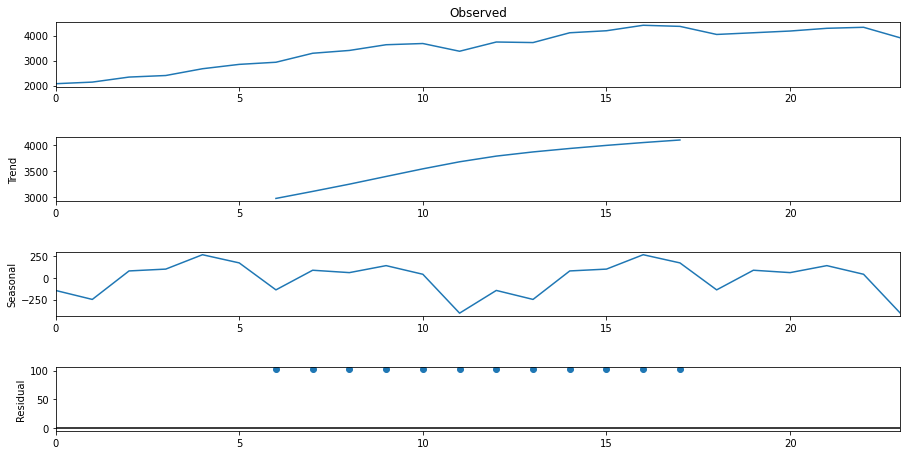

In [10]:
# Use simple seasonal decomposition to facilitate the guessing of the month
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(txn_cnt_vec, period=12, model='additive')
fig = decomp.plot()
fig.set_size_inches(14, 7)

### Transaction Gap
To explore if there's a chance to guess the real meanings of `shop_tag`s, I analyze the time gap between two transactions on the same `shop_tag` for each client. From this analysis, we can varify if **closer** transactions have stronger effect on the next transaction basket. Notice that for those `shop_tag`s having not been consumed so far or only once, I filter them out to facilitate the better quality of visualization.

#### Analysis and Observation 
1. Transaction gaps for all `shop_tag`s seem to follow power law, varifying the assumption that closer transactions have stronger motivation for clients to buy them again in the near months.

<div class='alert alert-block alert-warning'>
    <p>2. An interesting phenomenon occurs at value bin 10 ~ 11, and I've not come up with any idea about why it behaves like this.</p>
</div>

3. If samples with transaction gaps greater than 23 are included, value bin 23 ~ 24 will dominate the plot. And, it again introduces the idea that each `shop_tag` has its own loyal clients. In other words, clients make transactions on the specific subsets of `shop_tag`s.
4. There are some `shop_tag`s show the property of yearly transaction (*e.g.*, `17` and `34`), because value bin 11 ~ 12 has the most number of clients.

100%|██████████| 49/49 [00:17<00:00,  2.85it/s]


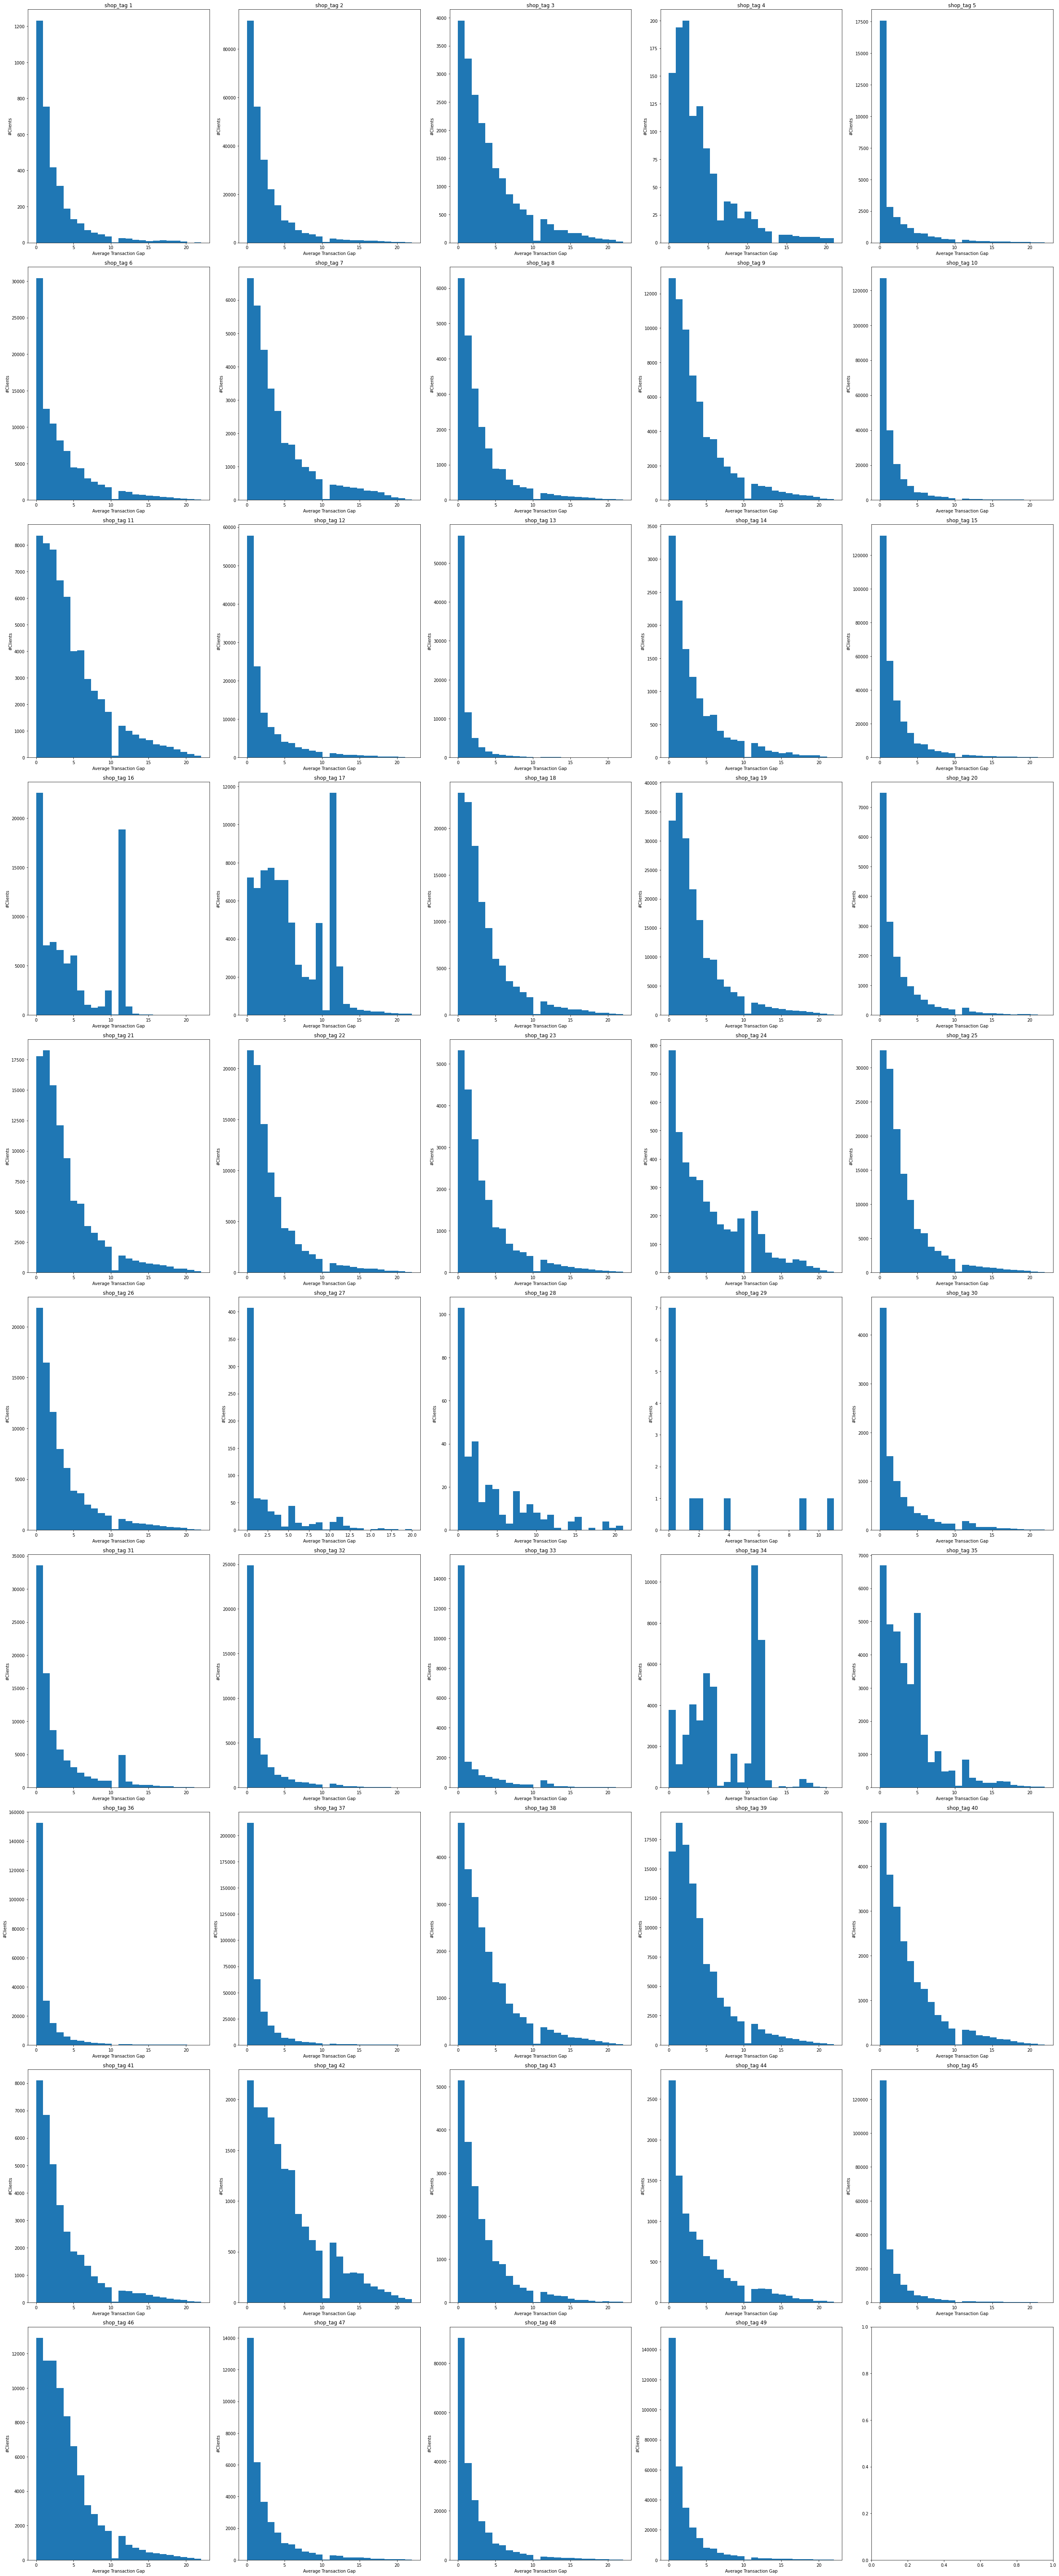

In [4]:
# Analyze transaction gap to see if the closer transaction 
# has the stronger effect on the next transaction basket
# txn_gap_vecs = get_txn_gap_vecs(df)
# with open("./data/processed/txn_gap_vecs.pkl", 'wb') as f:
#     pickle.dump(txn_gap_vecs, f)

# Load transaction gap vectors
with open("./data/processed/txn_gap_vecs.pkl", 'rb') as f:
    txn_gap_vecs = pickle.load(f)
    
n_cols = 5
fig, axs = plt.subplots(nrows= 10, ncols=n_cols, figsize=(35, 85))
for i in tqdm(range(N_SHOP_TAGS)):
    gaps = []
    for chid, txn_gap_vec in txn_gap_vecs.items():
        if txn_gap_vec[i] > 23:
            # Exclude the situations that there's no transaction
            # or only one appear in the records
            continue
        gaps.append(txn_gap_vec[i])
    axs[i//n_cols, i%n_cols].hist(x=gaps, bins=24)
    axs[i//n_cols, i%n_cols].set_title(f"shop_tag {i+1}")
    axs[i//n_cols, i%n_cols].set_xlabel(f"Average Transaction Gap")
    axs[i//n_cols, i%n_cols].set_ylabel("#Clients")
    del gaps
plt.tight_layout()

2. Past behavior of those having no next basket

In [9]:
df[df['chid'] == 10321420].head()

,dt,chid,shop_tag,txn_cnt,txn_amt,domestic_offline_cnt,domestic_online_cnt,overseas_offline_cnt,overseas_online_cnt,domestic_offline_amt_pct,domestic_online_amt_pct,overseas_offline_amt_pct,overseas_online_amt_pct,card_1_txn_cnt,card_2_txn_cnt,card_3_txn_cnt,card_4_txn_cnt,card_5_txn_cnt,card_6_txn_cnt,card_7_txn_cnt,card_8_txn_cnt,card_9_txn_cnt,card_10_txn_cnt,card_11_txn_cnt,card_12_txn_cnt,card_13_txn_cnt,card_14_txn_cnt,card_other_txn_cnt,card_1_txn_amt_pct,card_2_txn_amt_pct,card_3_txn_amt_pct,card_4_txn_amt_pct,card_5_txn_amt_pct,card_6_txn_amt_pct,card_7_txn_amt_pct,card_8_txn_amt_pct,card_9_txn_amt_pct,card_10_txn_amt_pct,card_11_txn_amt_pct,card_12_txn_amt_pct,card_13_txn_amt_pct,card_14_txn_amt_pct,card_other_txn_amt_pct,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
67404,1,10321420,49,1,5773.036485,1,0,0,0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,4,5,1,99,15,79291.240239,1,4,1
67414,1,10321420,37,1,5773.036485,1,0,0,0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,4,5,1,99,15,79291.240239,1,4,1
67422,1,10321420,47,4,7833.046850,0,4,0,0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,4,5,1,99,15,79291.240239,1,4,1
67428,1,10321420,48,1,5773.036485,1,0,0,0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,4,5,1,99,15,79291.240239,1,4,1
722029,10,10321420,10,5,62363.670461,0,5,0,0,0.0,1.0,0.0,0.0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4,5,1,99,15,87397.101503,1,4,1


In [15]:
test = df[df['card_1_txn_cnt'] < 0]
record = []
for i, row in test.iterrows():
    txn_cnt = [col for col in [f'card_{j}_txn_cnt' for j in range(2, 15)] if row[col] != 0]
    if len(txn_cnt) != 0:
        record.append(row)
len(record)

65